In [1]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/ipyk

In [2]:
import ssl
# on macOS this lets NLTK’s downloader ignore the SSL cert issue
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
nltk.download("punkt")
nltk.download("stopwords")    # if you haven’t already
nltk.download("wordnet")      # for your lemmatizer
nltk.download("omw-1.4")      # WordNet’s multilingual data



[nltk_data] Downloading package punkt to /Users/anikabasu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_theme(style="whitegrid")  # sets the grid + color palette
sns.despine()                     # optional, removes top/right spines
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 640x480 with 0 Axes>

In [4]:
df = pd.read_csv("cycop_bert_model_cyberbullying_tweets.csv")

In [5]:
df.head

<bound method NDFrame.head of                                               tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47692 rows x 2 columns]>

In [6]:
#Rename the columns using shorter words for easier reference.
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [7]:
#Check for duplicates
df.duplicated().sum()
#removing duplicates
df = df[~df.duplicated()]

In [8]:
#check class balance 
df.label.value_counts()
#The classes looked balanged (around 7900 per category)

label
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [9]:
import ssl
# on macOS this lets NLTK’s downloader ignore the SSL cert issue
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
nltk.download("punkt")
nltk.download("stopwords")    # if you haven’t already
nltk.download("wordnet")      # for your lemmatizer
nltk.download("omw-1.4")      # WordNet’s multilingual data


[nltk_data] Downloading package punkt to /Users/anikabasu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
import os, ssl, nltk, certifi, requests, io, zipfile

# 1) SSL bypass for macOS
ssl._create_default_https_context = ssl._create_unverified_context

# 2) Make sure ~/nltk_data is in NLTK’s search path
nltk.data.path.insert(0, os.path.expanduser("~/nltk_data"))

# 3) Download & unzip punkt properly
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/tokenizers/punkt.zip"
r = requests.get(url, verify=certifi.where()); r.raise_for_status()
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(os.path.expanduser("~/nltk_data/tokenizers"))

# 4) Now re-download your corpora if needed
nltk.download("stopwords",   download_dir=os.path.expanduser("~/nltk_data"))
nltk.download("wordnet",     download_dir=os.path.expanduser("~/nltk_data"))
nltk.download("omw-1.4",     download_dir=os.path.expanduser("~/nltk_data"))

print("Done.")


Done.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anikabasu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
import spacy

# load only the tokenizer + tagger (skip parser/ner to save memory)
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

In [12]:
#Data preprocessing -- using regex

# Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, "")

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    doc = nlp(text)
    # join each token’s .lemma_, preserving your whitespace-split logic
    return " ".join(token.lemma_ for token in doc)


# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [13]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]
df.head()

,text,label,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thank head concern another angry dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretend kurdish account like isla...


In [14]:
#check duplicates after cleaning
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets')

There are around 6251 duplicated tweets


In [15]:
df.drop_duplicates("text_clean", inplace=True)
df.label.value_counts()

label
religion               7916
age                    7817
ethnicity              7418
gender                 7282
not_cyberbullying      6065
other_cyberbullying    4907
Name: count, dtype: int64

In [16]:
#Lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes, I am removing the tweets labeled belonging to this class.
df = df[df["label"]!="other_cyberbullying"]

#defining a list of the classes names
labels = ["religion","age","ethnicity","gender","not bullying"]

#label encoding
df['label'] = df['label'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

#removing tweets that are too long (with more than 100 words).
df['text_len'] = [len(text.split()) for text in df.text_clean]
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

#getting the length of the longest tweet
df['text_len'] = [len(text.split()) for text in df.text_clean]
max_len = np.max(df['text_len'])
max_len 

/var/folders/cx/m8jkwtj96r5ghhzll1wzg7640000gn/T/ipykernel_16081/1374458964.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


np.int64(31)

Bert Classification
Loading a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

In [17]:
X = df['text_clean'].values
y = df['label'].values
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
#Train-Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [18]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5012],
       [   1, 4967],
       [   2, 4708],
       [   3, 4627],
       [   4, 3879]])

In [19]:
#oversampling the training set to the majority class due to unbalanced data
ros = RandomOverSampler() 
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [20]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5012],
       [   1, 5012],
       [   2, 5012],
       [   3, 5012],
       [   4, 5012]])

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
#defning custom tokenizer using the loaded tokenizer
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


In [24]:
MAX_LEN = 128

In [25]:
#tokenize the train, validation and test tweets using the custom define tokenizer.
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
import numpy as np
import torch
print(torch.__config__.show())   # check that it lists NumPy support


PyTorch built with:
  - GCC 4.2
  - C++ Version: 201703
  - clang 13.1.6
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220801 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201811
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_13.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DUSE_PYTORCH_METAL_EXPORT -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DUSE_COREML_DELEGATE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=braced-scalar-init -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing

In [32]:
# assuming your labels are integers, you probably want a LongTensor:
train_labels = torch.tensor(y_train_os, dtype=torch.long)
val_labels   = torch.tensor(y_valid,   dtype=torch.long)
test_labels  = torch.tensor(y_test,    dtype=torch.long)


In [36]:
# To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.
batch_size = 32

In [37]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [38]:
#Creating a custom BERT classifier class, including the original BERT model and additional dense layers.
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [39]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
#specify the use of GPU 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [41]:
#intialize the BERT model
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

/Users/anikabasu/Development/CyCopBERTBot/cycopenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model tha

In [73]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = ((preds == batch_labels).sum().item() / len(batch_labels)) * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [44]:
bert_classifier.to(device)

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

✅ TorchScript model saved at model_save/cycop_model.pt


In [49]:
import torch
print("cuda available?", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Torch CUDA version:", torch.version.cuda)


cuda available? False
GPU count: 0
Torch CUDA version: None


In [74]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.098886   |  1067.82 
   200    |   0.090350   |  1030.89 
   300    |   0.087802   |  1026.95 
   400    |   0.096098   |  1031.99 
   500    |   0.078413   |  1032.12 
   600    |   0.070846   |  1029.70 
   700    |   0.099924   |  1028.88 
   783    |   0.089795   |  839.79  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.089010    |  0.204663  |       94.09       |  8628.25 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.066245   |  1030.56 
   200    |   0.065237   |  1025.99 
   3

In [114]:
import os, torch

# 1) Make sure output folder exists
os.makedirs("model_save", exist_ok=True)

# 2) Put your wrapper into eval mode and move to CPU
bert_classifier.eval()
bert_classifier.cpu()

# 3) Create a dummy input that matches your tokenize→tensor pipeline:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# pick a typical max length; must match what you traced with
dummy_tokens = tokenizer(
    "This is a dummy",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)

# 4) Trace it—note: we feed only the input_ids & attention_mask
scripted = torch.jit.trace(
    bert_classifier, 
    (dummy_tokens["input_ids"], dummy_tokens["attention_mask"])
)

# 5) Save the traced model
scripted.save("model_save/cycop_model.pt")
print("✅ TorchScript model saved at model_save/cycop_model.pt")


✅ TorchScript model saved at model_save/cycop_model.pt


In [ ]:
# 2.1 check you’re on the right repo
#git remote -v
# you should see origin pointing to https://github.com/AnikaGBasu/CyCopDiscordBot.git

# 2.2 stage the new files
#git add model_save/

# 2.3 commit them
#git commit -m "Add fine-tuned BERT model and tokenizer"

# 2.4 push up to GitHub
#git push origin main

In [78]:
#Function to the model the test data.
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit, dim=1).cpu().tolist()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [79]:
#get the class predictions of the test data
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [80]:
#Function to create confusion matrix
def conf_matrix(y, y_pred, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [82]:
# e.g. if your int labels are
#   0 → religion
#   1 → age
#   2 → ethnicity
#   3 → gender
#   4 → not_cyberbullying
CLASS_IDS   = [0, 1, 2, 3, 4]
CLASS_NAMES = [
  "religion",
  "age",
  "ethnicity",
  "gender",
  "not_cyberbullying"
]


In [83]:
from sklearn.metrics import classification_report

print(
  classification_report(
    y_test,
    bert_preds,
    labels=CLASS_IDS,
    target_names=CLASS_NAMES,
    zero_division=0         # optional: avoids warnings if any class has zero predictions
  )
)


                   precision    recall  f1-score   support

         religion       0.96      0.97      0.97      1566
              age       0.99      0.98      0.98      1552
        ethnicity       0.99      0.99      0.99      1472
           gender       0.93      0.90      0.91      1446
not_cyberbullying       0.84      0.85      0.84      1213

         accuracy                           0.94      7249
        macro avg       0.94      0.94      0.94      7249
     weighted avg       0.94      0.94      0.94      7249



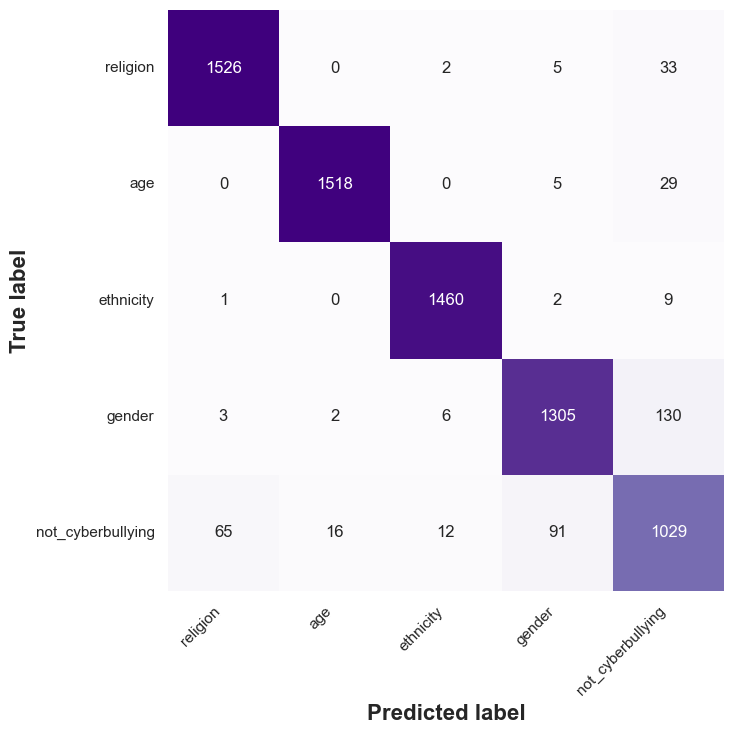

In [86]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) define your strings in the same order as the integer labels 0→4
class_names = [
    "religion",       # label 0
    "age",   # label 1
    "ethnicity",     # label 2
    "gender",       # label 3
    "not_cyberbullying"          # label 4
]

def conf_matrix(y_true, y_pred, names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7.5,7.5))
    sns.heatmap(
      cm,
      annot=True,
      fmt="g",
      cmap="Purples",
      cbar=False,
      xticklabels=names,    # <— here!
      yticklabels=names     # <— and here
    )
    ax.set_xlabel("Predicted label", fontsize=16)
    ax.set_ylabel("True label", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# call it:
conf_matrix(y_test, bert_preds, class_names)


In [88]:
def print_predictions(X_test, y_test, y_pred, num_instances=5):
    for i in range(num_instances):
        text = X_test[i]
        true_label = labels[y_test[i]]
        predicted_label = labels[y_pred[i]]
        
        # Find the matching row in df based on the text value
        matching_row = df[df['text_clean'] == text]
        
        if not matching_row.empty:
            actual_text = matching_row['text'].iloc[0]
            actual_label = matching_row['label'].iloc[0]
            actual_label_text = labels[actual_label]
            
            print("Input Text:", actual_text)
            print("Actual Label:", actual_label_text)
            print("Predicted Label:", predicted_label)
            
            print("--------------")

print_predictions(X_test, y_test, bert_preds, num_instances=5)


Input Text: Really weird that a heterosexual Christian woman who has a right view of the rainbow gets called gay for it. But hey, you do you.
Actual Label: tensor(1)
Predicted Label: tensor(1)
--------------
Input Text: Also Rihanna is my fave. Shes that popular girl in school who’s actually nice &amp; sticks up to the bully who thinks their popular cause they continuously put other pple down to look “cool” in front of their friends.
Actual Label: tensor(1)
Predicted Label: tensor(1)
--------------
Input Text: I am a straight, Catholic, Christian woman who believes in lgbtq+ rights. If you don’t like that unfollow me. And for the lgbtq+ community, I love you all for who you are. #HappyPride
Actual Label: tensor(1)
Predicted Label: tensor(1)
--------------
Input Text: girl it was probably some passive aggressive ass homophobia?? i could fight in high school so i never got bullied LMFAOOO
Actual Label: tensor(1)
Predicted Label: tensor(1)
--------------
Input Text: People just will never